<br>

<div align=center><font color=maroon size=6 style="line-height:40px;"><b>Object detection with TF Hub</b></font></div>

<br>

<font size=4><b>References:</b></font>
1. TF2 official tutorials: <a href="https://www.tensorflow.org/tutorials" style="text-decoration:none;">TensorFlow Tutorials</a> 
    * `TensorFlow > Learn > TensorFlow Core > `Tutorials > <a href="" style="text-decoration:none;">Object detection with TF Hub</a>
        * Run in <a href="https://github.com/tensorflow/hub/blob/master/examples/colab/tf2_object_detection.ipynb" style="text-decoration:none;">External Resource</a>

<br>
<br>
<br>

Welcome to the TensorFlow Hub Object Detection Colab! This notebook will take you through the steps of running an "out-of-the-box" object detection model on images.

<br>

## More models

<a href="https://tfhub.dev/tensorflow/collections/object_detection/1" style="text-decoration:none;">This</a> collection contains TF2 object detection models that have been trained on the COCO 2017 dataset. <a href="https://tfhub.dev/s?module-type=image-object-detection" style="text-decoration:none;">Here</a> you can find all object detection models that are currently hosted on <a href="https://tfhub.dev/" style="text-decoration:none;">tfhub.dev</a>.

<br>

In [1]:
# This Colab requires TF 2.5.
# !pip install -U "tensorflow>=2.5"

<br>

In [2]:
import os
import pathlib

import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from six.moves.urllib.request import urlopen

In [3]:
import tensorflow as tf
import tensorflow_hub as hub

tf.get_logger().setLevel('ERROR')

In [4]:
print(tf.__version__)

2.8.0


<br>

## Utilities

Run the following cell to create some utils that will be needed later:

* Helper method to load an image
* Map of Model Name to TF Hub handle
* List of tuples with Human Keypoints for the COCO 2017 dataset. This is needed for models with keypoints.

In [5]:
# @title Run this!!

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    
    image = None
    if (path.startswith('http')):
        response = urlopen(path)
        image_data = response.read()
        image_data = BytesIO(image_data)
        image = Image.open(image_data)
        
    else:
        image_data = tf.io.gfile.GFile(path, 'rb').read()
        image = Image.open(BytesIO(image_data))
        
    (im_width, im_height) = image.size
    
    return np.array(image.getdata()).reshape((1, im_height, im_width, 3)).astype(np.uint8)

<br>

In [6]:
ALL_MODELS = {
    'CenterNet HourGlass104 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512/1',
    'CenterNet HourGlass104 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512_kpts/1',
    'CenterNet HourGlass104 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024/1',
    'CenterNet HourGlass104 Keypoints 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024_kpts/1',
    'CenterNet Resnet50 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512/1',
    'CenterNet Resnet50 V1 FPN Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512_kpts/1',
    'CenterNet Resnet101 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet101v1_fpn_512x512/1',
    'CenterNet Resnet50 V2 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512/1',
    'CenterNet Resnet50 V2 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512_kpts/1',
    'EfficientDet D0 512x512' : 'https://tfhub.dev/tensorflow/efficientdet/d0/1',
    'EfficientDet D1 640x640' : 'https://tfhub.dev/tensorflow/efficientdet/d1/1',
    'EfficientDet D2 768x768' : 'https://tfhub.dev/tensorflow/efficientdet/d2/1',
    'EfficientDet D3 896x896' : 'https://tfhub.dev/tensorflow/efficientdet/d3/1',
    'EfficientDet D4 1024x1024' : 'https://tfhub.dev/tensorflow/efficientdet/d4/1',
    'EfficientDet D5 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d5/1',
    'EfficientDet D6 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d6/1',
    'EfficientDet D7 1536x1536' : 'https://tfhub.dev/tensorflow/efficientdet/d7/1',
    'SSD MobileNet v2 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2',
    'SSD MobileNet V1 FPN 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v1/fpn_640x640/1',
    'SSD MobileNet V2 FPNLite 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1',
    'SSD MobileNet V2 FPNLite 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_640x640/1',
    'SSD ResNet50 V1 FPN 640x640 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_640x640/1',
    'SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_1024x1024/1',
    'SSD ResNet101 V1 FPN 640x640 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_640x640/1',
    'SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_1024x1024/1',
    'SSD ResNet152 V1 FPN 640x640 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_640x640/1',
    'SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_1024x1024/1',
    'Faster R-CNN ResNet50 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1',
    'Faster R-CNN ResNet50 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_1024x1024/1',
    'Faster R-CNN ResNet50 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_800x1333/1',
    'Faster R-CNN ResNet101 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_640x640/1',
    'Faster R-CNN ResNet101 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_1024x1024/1',
    'Faster R-CNN ResNet101 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_800x1333/1',
    'Faster R-CNN ResNet152 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_640x640/1',
    'Faster R-CNN ResNet152 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_1024x1024/1',
    'Faster R-CNN ResNet152 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_800x1333/1',
    'Faster R-CNN Inception ResNet V2 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_640x640/1',
    'Faster R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_1024x1024/1',
    'Mask R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1'
}

<br>

In [7]:
IMAGES_FOR_TEST = {
    'Beach' : 'models/research/object_detection/test_images/image2.jpg',
    'Dogs' : 'models/research/object_detection/test_images/image1.jpg',
    # By Heiko Gorski, Source: https://commons.wikimedia.org/wiki/File:Naxos_Taverna.jpg
    'Naxos Taverna' : 'https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg',
    # Source: https://commons.wikimedia.org/wiki/File:The_Coleoptera_of_the_British_islands_(Plate_125)_(8592917784).jpg
    'Beatles' : 'https://upload.wikimedia.org/wikipedia/commons/1/1b/The_Coleoptera_of_the_British_islands_%28Plate_125%29_%288592917784%29.jpg',
    # By Américo Toledano, Source: https://commons.wikimedia.org/wiki/File:Biblioteca_Maim%C3%B3nides,_Campus_Universitario_de_Rabanales_007.jpg
    'Phones' : 'https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg/1024px-Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg',
    # Source: https://commons.wikimedia.org/wiki/File:The_smaller_British_birds_(8053836633).jpg
    'Birds' : 'https://upload.wikimedia.org/wikipedia/commons/0/09/The_smaller_British_birds_%288053836633%29.jpg',
}

In [8]:
COCO17_HUMAN_POSE_KEYPOINTS = [(0, 1), 
                               (0, 2),
                               (1, 3),
                               (2, 4),
                               (0, 5), 
                               (0, 6),
                               (5, 7),
                               (7, 9),
                               (6, 8),
                               (8, 10),
                               (5, 6),
                               (5, 11),
                               (6, 12),
                               (11, 12),
                               (11, 13),
                               (13, 15),
                               (12, 14),
                               (14, 16)]

<br>
<br>
<br>

## Visualization tools

<font style="color:maroon;font-size:120%">To visualize the images with the proper detected boxes, keypoints and segmentation, we will use the TensorFlow Object Detection API. To install it we will clone the repo.</font>

In [9]:
# Clone the tensorflow models repository
!git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
Updating files:  92% (2861/3079)
Updating files:  93% (2864/3079)
Updating files:  94% (2895/3079)
Updating files:  95% (2926/3079)
Updating files:  96% (2956/3079)
Updating files:  97% (2987/3079)
Updating files:  98% (3018/3079)
Updating files:  99% (3049/3079)
Updating files: 100% (3079/3079)
Updating files: 100% (3079/3079), done.


<br>

Intalling the Object Detection API

<font color=maroon>【锐平】：在 windows 环境下，原文中的下面这个代码块无法执行。</font>

In [ ]:
# %%bash
# sudo apt install -y protobuf-compiler
# cd models/research/
# protoc object_detection/protos/*.proto --python_out=.
# cp object_detection/packages/tf2/setup.py .
# python -m pip install .

<br>
<br>
<br>

In [9]:
# 尝试安装 https://pypi.org/project/protobuf-compiler/
#
#

# pip install protobuf-compiler

# 安装失败。原因：
#  ERROR: Failed building wheel for grpcio
#   Running setup.py clean for grpcio
# Failed to build grpcio

In [10]:
# 尝试直接下载安装包来安装
# 官网：https://github.com/protocolbuffers/protobuf/releases
# 下载版本：protoc-21.1-win64.zip

# 参考文献：
# ①
# Mac, Linux, Windows 安裝 Protocol Buffer (protobuf) compiler 方式：
# https://hoohoo.top/blog/mac-linux-windows-install-protocol-buffer-protobuf-compiler-way/
# ②
# windows 下使用 protobuf：
# https://blog.csdn.net/liupeifeng3514/article/details/78985575

In [11]:
!protoc --version

libprotoc 3.14.0


<br>
<br>
<br>

```python
==================================================以下为试验===================================================
```

In [14]:
%%cmd
pwd

Microsoft Windows [Version 10.0.19044.1706]
(c) Microsoft Corporation銆備繚鐣欐墍鏈夋潈鍒┿��

(tfg) D:\KeepStudy\0_Coding\Tensorflow\TF2\tf2_Core_1_tutorials\2 Advanced\2-3 Images>pwd
/d/KeepStudy/0_Coding/Tensorflow/TF2/tf2_Core_1_tutorials/2 Advanced/2-3 Images

(tfg) D:\KeepStudy\0_Coding\Tensorflow\TF2\tf2_Core_1_tutorials\2 Advanced\2-3 Images>

In [16]:
%%cmd
chdir

Microsoft Windows [Version 10.0.19044.1706]
(c) Microsoft Corporation銆備繚鐣欐墍鏈夋潈鍒┿��

(tfg) D:\KeepStudy\0_Coding\Tensorflow\TF2\tf2_Core_1_tutorials\2 Advanced\2-3 Images>chdir
D:\KeepStudy\0_Coding\Tensorflow\TF2\tf2_Core_1_tutorials\2 Advanced\2-3 Images

(tfg) D:\KeepStudy\0_Coding\Tensorflow\TF2\tf2_Core_1_tutorials\2 Advanced\2-3 Images>

In [17]:
%%bash
pwd

/mnt/d/KeepStudy/0_Coding/Tensorflow/TF2/tf2_Core_1_tutorials/2 Advanced/2-3 Images


In [18]:
%%bash
protoc --version

-bash: line 1: protoc: command not found


CalledProcessError: Command 'b'protoc --version\n'' returned non-zero exit status 127.

In [21]:
%%bash
# cd D:/Programs/protoc-21.1-win64/bin
# 报错：-bash: line 1: cd: D:/Programs/protoc-21.1-win64/bin: No such file or directory

cd /mnt/d/Programs/protoc-21.1-win64/bin
ls -al
protoc --version

# 报错的原因是因为上面安装的 protoc-21.1-win64.zip 是 windows 版的，不是 Linux 版的。

total 7960
drwxrwxrwx 1 rp rp    4096 Jun  5 22:18 .
drwxrwxrwx 1 rp rp    4096 Jun  5 22:18 ..
-rwxrwxrwx 1 rp rp 8149262 Jan  1  1980 protoc.exe


-bash: line 6: protoc: command not found


CalledProcessError: Command 'b'# cd D:/Programs/protoc-21.1-win64/bin\n# \xe6\x8a\xa5\xe9\x94\x99\xef\xbc\x9a-bash: line 1: cd: D:/Programs/protoc-21.1-win64/bin: No such file or directory\n\ncd /mnt/d/Programs/protoc-21.1-win64/bin\nls -al\nprotoc --version\n\n'' returned non-zero exit status 127.

<br>

```python
==================================================试验结束===================================================
```

<br>
<br>
<br>

In [22]:
%%cmd
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Microsoft Windows [Version 10.0.19044.1706]
(c) Microsoft Corporation銆備繚鐣欐墍鏈夋潈鍒┿��

(tfg) D:\KeepStudy\0_Coding\Tensorflow\TF2\tf2_Core_1_tutorials\2 Advanced\2-3 Images>cd models/research/

(tfg) D:\KeepStudy\0_Coding\Tensorflow\TF2\tf2_Core_1_tutorials\2 Advanced\2-3 Images\models\research>protoc object_detection/protos/*.proto --python_out=.

(tfg) D:\KeepStudy\0_Coding\Tensorflow\TF2\tf2_Core_1_tutorials\2 Advanced\2-3 Images\models\research>cp object_detection/packages/tf2/setup.py .

(tfg) D:\KeepStudy\0_Coding\Tensorflow\TF2\tf2_Core_1_tutorials\2 Advanced\2-3 Images\models\research>python -m pip install .
Processing d:\keepstudy\0_coding\tensorflow\tf2\tf2_core_1_tutorials\2 advanced\2-3 images\models\research
  Using cached Cython-0.29.30-py2.py3-none-any.whl (985 kB)
  Using cached tf_slim-1.1.0-py2.py3-none-any.whl (352 kB)
  Using cached pycocotools-2.0.4-cp39-cp39-win_amd64.whl
  Using cached tf_models_official-2.9.2-py2.py3-none-any.whl (2.1 MB)
  Using cached tensorflow-

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-gpu 2.8.0 requires keras<2.9,>=2.8.0rc0, but you have keras 2.9.0 which is incompatible.
tensorflow-gpu 2.8.0 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.9.0 which is incompatible.


<br>

In [29]:
# 陈锐平 try
a = !cd models/research/
print(a)
print()

!pwd

[]

/d/KeepStudy/0_Coding/Tensorflow/TF2/tf2_Core_1_tutorials/2 Advanced/2-3 Images


<br>
<br>

Now we can import the dependencies we will need later.

In [9]:
# from models.research.object_detection import utils
# 正常运行

In [10]:
# from models.research.object_detection.utils import label_map_util
# 报错：
# ModuleNotFoundError: No module named 'object_detection'

In [11]:
# import sys
# sys.path.append("""D:/KeepStudy/0_Coding/Tensorflow/TF2/tf2_Core_1_tutorials/2 Advanced/2-3 Images/models/research""")

# 曾报错:
# ValueError: stat: embedded null character in path
# 因为上面路径的分隔符一开始是采用 windows 的路径形式，即 “\”
# 参考文献：https://blog.csdn.net/quintind/article/details/77371402
# 
# 另，路径中也不要将 "/object_detection" 这个文件夹包含进去。
# D:/KeepStudy/0_Coding/Tensorflow/TF2/tf2_Core_1_tutorials/2 Advanced/2-3 Images/models/research/object_detection
# 不然下面导入："from models.research.object_detection.utils import label_map_util" 等也找不到
# object_detection 模块。

<br>

```python
安装完 protoc-21.1-win64.zip

并根据 https://blog.csdn.net/liupeifeng3514/article/details/78985575 设置环境变量以及初步了解 protoc 的使用。

执行以下代码块：
%%cmd
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

下面的 "from models.research.object_detection.utils import label_map_util" 等就能正常导入了。
```

In [23]:
from models.research.object_detection.utils import label_map_util
from models.research.object_detection.utils import visualization_utils as viz_utils
from models.research.object_detection.utils import ops as utils_ops

%matplotlib inline

<br>

## Load label map data (for plotting).

Label maps correspond index numbers to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`. Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine.

We are going, for simplicity, to load from the repository that we loaded the Object Detection API code

In [31]:
PATH_TO_LABELS = './models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, 
                                                                    use_display_name=True)

<br>
<br>
<br>

## Build a detection model and load pre-trained model weights

Here we will choose which Object Detection model we will use. Select the architecture and it will be loaded automatically. If you want to change the model to try other architectures later, just change the next cell and execute following ones.

**Tip**: if you want to read more details about the selected model, you can follow the link (model handle) and read additional documentation on TF Hub. After you select a model, we will print the handle to make it easier.

In [24]:
#@title Model Selection { display-mode: "form", run: "auto" }
model_display_name = 'CenterNet HourGlass104 Keypoints 512x512' # @param ['CenterNet HourGlass104 512x512','CenterNet HourGlass104 Keypoints 512x512','CenterNet HourGlass104 1024x1024','CenterNet HourGlass104 Keypoints 1024x1024','CenterNet Resnet50 V1 FPN 512x512','CenterNet Resnet50 V1 FPN Keypoints 512x512','CenterNet Resnet101 V1 FPN 512x512','CenterNet Resnet50 V2 512x512','CenterNet Resnet50 V2 Keypoints 512x512','EfficientDet D0 512x512','EfficientDet D1 640x640','EfficientDet D2 768x768','EfficientDet D3 896x896','EfficientDet D4 1024x1024','EfficientDet D5 1280x1280','EfficientDet D6 1280x1280','EfficientDet D7 1536x1536','SSD MobileNet v2 320x320','SSD MobileNet V1 FPN 640x640','SSD MobileNet V2 FPNLite 320x320','SSD MobileNet V2 FPNLite 640x640','SSD ResNet50 V1 FPN 640x640 (RetinaNet50)','SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)','SSD ResNet101 V1 FPN 640x640 (RetinaNet101)','SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)','SSD ResNet152 V1 FPN 640x640 (RetinaNet152)','SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)','Faster R-CNN ResNet50 V1 640x640','Faster R-CNN ResNet50 V1 1024x1024','Faster R-CNN ResNet50 V1 800x1333','Faster R-CNN ResNet101 V1 640x640','Faster R-CNN ResNet101 V1 1024x1024','Faster R-CNN ResNet101 V1 800x1333','Faster R-CNN ResNet152 V1 640x640','Faster R-CNN ResNet152 V1 1024x1024','Faster R-CNN ResNet152 V1 800x1333','Faster R-CNN Inception ResNet V2 640x640','Faster R-CNN Inception ResNet V2 1024x1024','Mask R-CNN Inception ResNet V2 1024x1024']
model_handle = ALL_MODELS[model_display_name]

print('Selected model:'+ model_display_name)
print('Model Handle at TensorFlow Hub: {}'.format(model_handle))

Selected model:CenterNet HourGlass104 Keypoints 512x512
Model Handle at TensorFlow Hub: https://tfhub.dev/tensorflow/centernet/hourglass_512x512_kpts/1


<br>
<br>
<br>

## Loading the selected model from TensorFlow Hub

Here we just need the model handle that was selected and use the Tensorflow Hub library to load it to memory.

In [27]:
# help(hub.load)

In [28]:
print("loading model...")
hub_model = hub.load(model_handle)
print("model loaded!")

loading model...


model loaded!


<br>
<br>
<br>

## Loading an image

Let's try the model on a simple image. To help with this, we provide a list of test images.

Here are some simple things to try out if you are curious:

* Try running inference on your own images, just upload them to colab and load the same way it's done in the cell below.
* Modify some of the input images and see if detection still works. Some simple things to try out here include flipping the image horizontally, or converting to grayscale (note that we still expect the input image to have 3 channels).


<font style="color:maroon;font-size:120%">**Be careful**: when using images with an alpha channel, the model expect 3 channels images and the alpha will count as a 4th.</font>

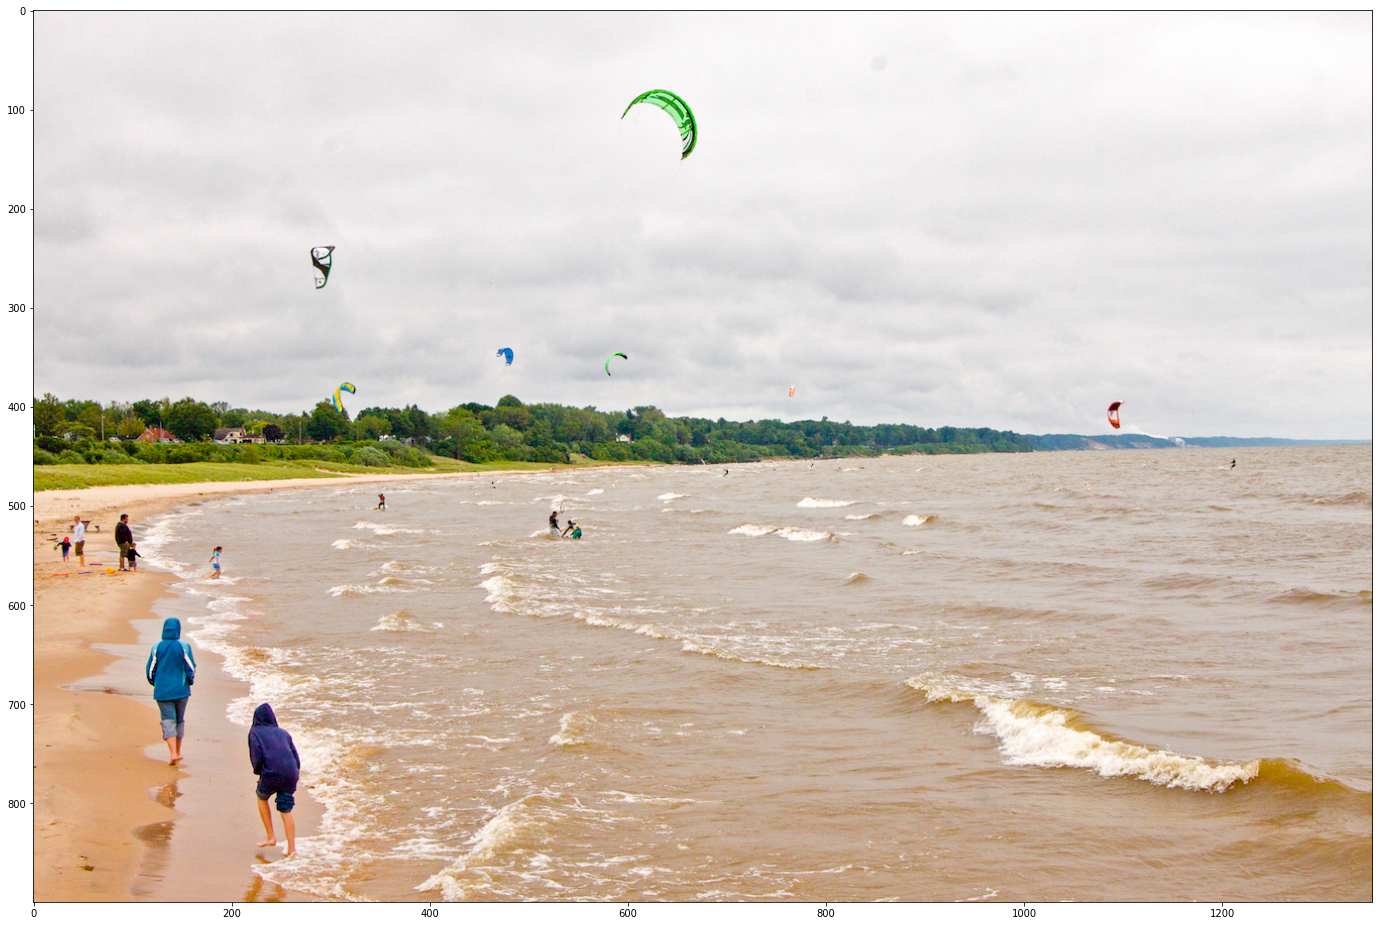

In [29]:
#@title Image Selection (don't forget to execute the cell!) { display-mode: "form"}
selected_image = 'Beach'            # @param ['Beach', 'Dogs', 'Naxos Taverna', 'Beatles', 'Phones', 'Birds']
flip_image_horizontally = False     #@param {type:"boolean"}
convert_image_to_grayscale = False  #@param {type:"boolean"}

image_path = IMAGES_FOR_TEST[selected_image]
image_np = load_image_into_numpy_array(image_path)


# Flip horizontally
if(flip_image_horizontally):
    image_np[0] = np.fliplr(image_np[0]).copy()
    

if(convert_image_to_grayscale):
    image_np[0] = np.tile( np.mean(image_np[0], 2, keepdims=True), 
                           (1, 1, 3)) \
                    .astype(np.uint8)


plt.figure(figsize=(24,32))
plt.imshow(image_np[0])
plt.show()

<br>
<br>
<br>

## Doing the inference

<font style="color:maroon;font-size:120%">To do the inference we just need to call our TF Hub loaded model.

Things you can try:

* Print out `result['detection_boxes']` and try to match the box locations to the boxes in the image. Notice that coordinates are given in normalized form (i.e., in the interval [0, 1]).


* inspect other output keys present in the result. A full documentation can be seen on the models documentation page (pointing your browser to the model handle printed earlier)</font>

In [32]:
# running inference
results = hub_model(image_np)

# different object detection models have additional results
# all of them are explained in the documentation
result = {key:value.numpy() for key, value in results.items()}
print(result.keys())

dict_keys(['detection_keypoint_scores', 'detection_classes', 'detection_keypoints', 'detection_scores', 'num_detections', 'detection_boxes'])


<br>

## Visualizing the results

Here is where we will need the TensorFlow Object Detection API to show the squares from the inference step (and the keypoints when available).

The full documentation of this method can be seen <a href="https://github.com/tensorflow/models/blob/master/research/object_detection/utils/visualization_utils.py" style="text-decoration:none;font-size:130%">here</a>.

Here you can, for example, set `min_score_thresh` to other values (between 0 and 1) to allow more detections in or to filter out more detections.

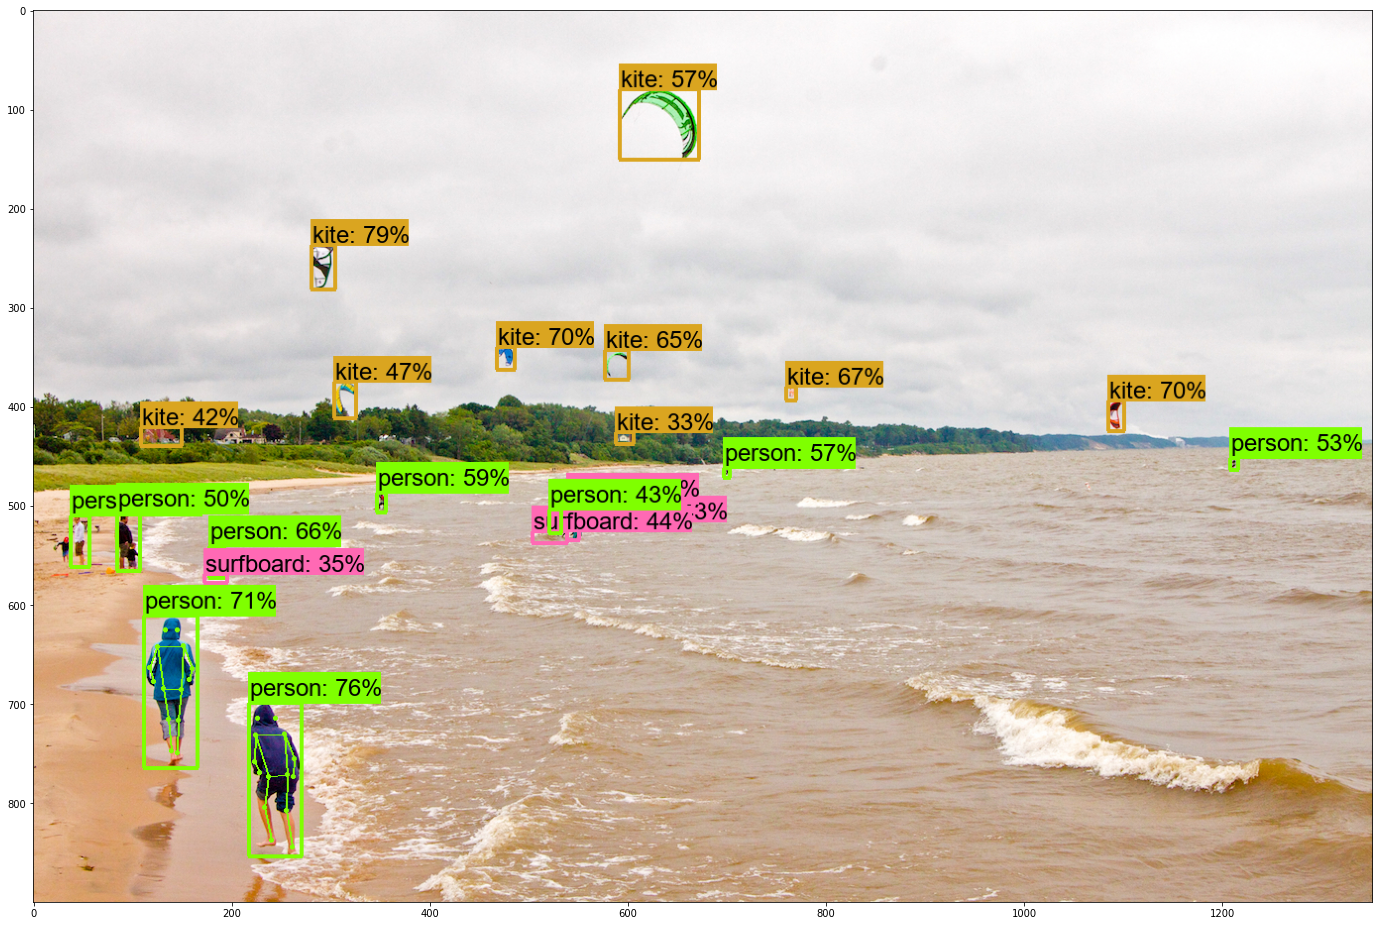

In [33]:
label_id_offset = 0
image_np_with_detections = image_np.copy()

# Use keypoints if available in detections
keypoints, keypoint_scores = None, None
if 'detection_keypoints' in result:
    keypoints = result['detection_keypoints'][0]
    keypoint_scores = result['detection_keypoint_scores'][0]



viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections[0],
      result['detection_boxes'][0],
      (result['detection_classes'][0] + label_id_offset).astype(int),
      result['detection_scores'][0],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False,
      keypoints=keypoints,
      keypoint_scores=keypoint_scores,
      keypoint_edges=COCO17_HUMAN_POSE_KEYPOINTS)



plt.figure(figsize=(24,32))
plt.imshow(image_np_with_detections[0])
plt.show()

<br>
<br>
<br>

## [Optional]

<font style="color:maroon;font-size:120%">Among the available object detection models there's Mask R-CNN and the output of this model allows instance segmentation.

To visualize it we will use the same method we did before but adding an aditional parameter: `instance_masks=output_dict.get('detection_masks_reframed', None)`</font>

In [36]:
# help(hub_model)

In [37]:
#@title Model Selection { display-mode: "form", run: "auto" }
model_display_name = 'Mask R-CNN Inception ResNet V2 1024x1024'
model_handle = ALL_MODELS[model_display_name]

print('Selected model:'+ model_display_name)
print('Model Handle at TensorFlow Hub: {}'.format(model_handle))

Selected model:Mask R-CNN Inception ResNet V2 1024x1024
Model Handle at TensorFlow Hub: https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1


In [38]:
print('loading model...')
hub_model = hub.load(model_handle)
print('model loaded!')

loading model...
model loaded!


In [39]:
# running inference
results = hub_model(image_np)

# different object detection models have additional results
# all of them are explained in the documentation
result = {key:value.numpy() for key, value in results.items()}
print(result.keys())

dict_keys(['detection_masks', 'detection_anchor_indices', 'class_predictions_with_background', 'proposal_boxes_normalized', 'rpn_objectness_predictions_with_background', 'rpn_box_predictor_features', 'detection_multiclass_scores', 'refined_box_encodings', 'rpn_features_to_crop', 'proposal_boxes', 'box_classifier_features', 'anchors', 'final_anchors', 'detection_classes', 'detection_boxes', 'num_detections', 'detection_scores', 'raw_detection_scores', 'rpn_box_encodings', 'raw_detection_boxes', 'num_proposals', 'mask_predictions', 'image_shape'])


<br>
<br>

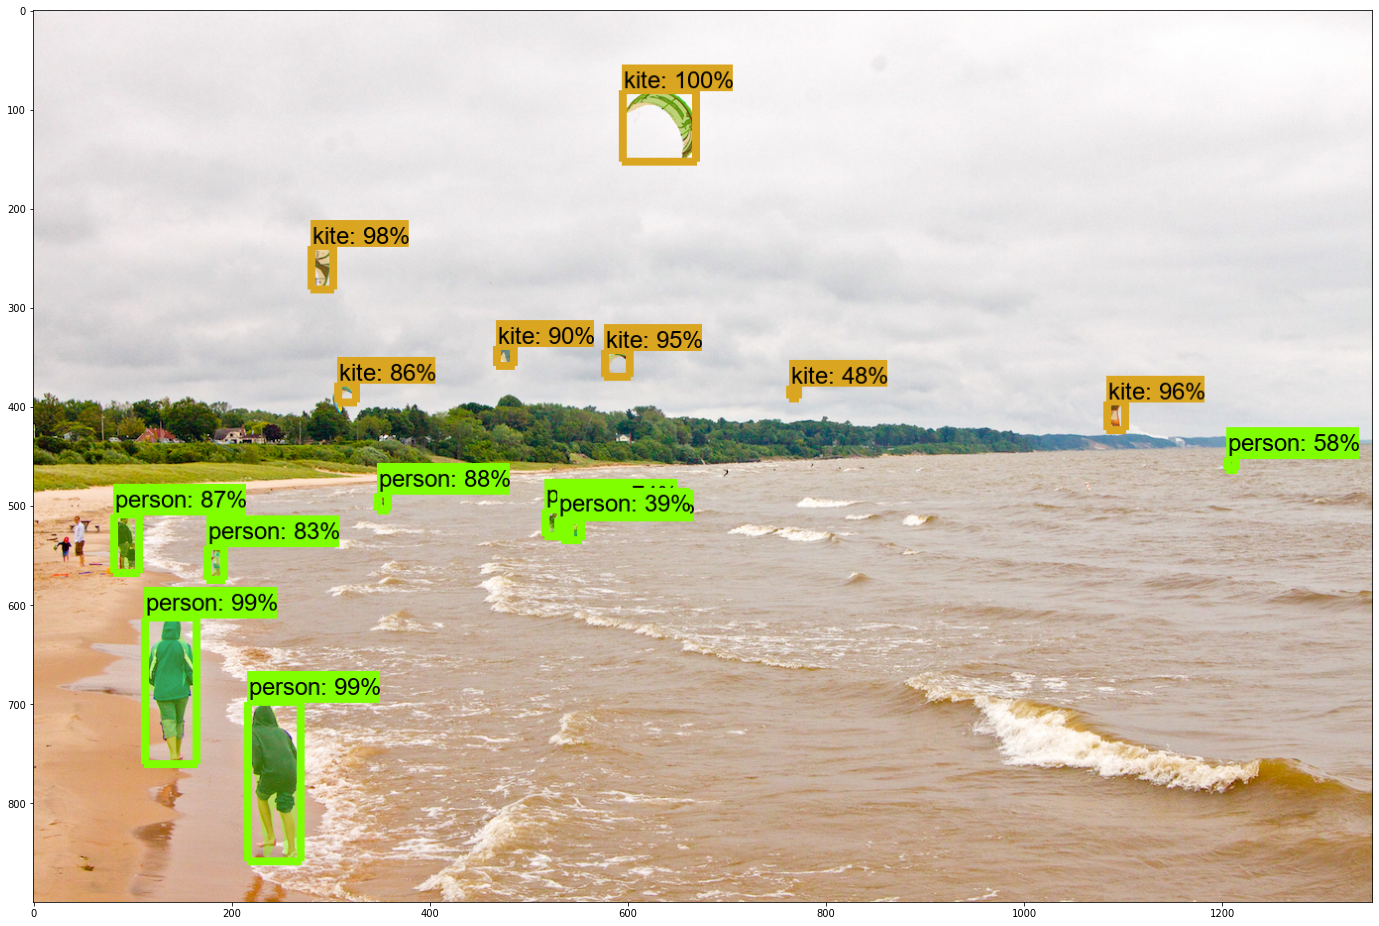

In [40]:
# Handle models with masks:
image_np_with_mask = image_np.copy()

if 'detection_masks' in result:
    # we need to convert np.arrays to tensors
    detection_masks = tf.convert_to_tensor(result['detection_masks'][0])
    detection_boxes = tf.convert_to_tensor(result['detection_boxes'][0])


# Reframe the bbox mask to the image size.
detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(detection_masks, 
                                                                      detection_boxes,
                                                                      image_np.shape[1], 
                                                                      image_np.shape[2])
detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5, tf.uint8)

result['detection_masks_reframed'] = detection_masks_reframed.numpy()


viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_mask[0],
      result['detection_boxes'][0],
      (result['detection_classes'][0] + label_id_offset).astype(int),
      result['detection_scores'][0],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False,
    
      instance_masks=result.get('detection_masks_reframed', None),
      line_thickness=8)

plt.figure(figsize=(24,32))
plt.imshow(image_np_with_mask[0])
plt.show()

<font style="color:maroon;font-size:120%">
    
<a href="" style="text-decoration:none;">
</a>

<br>
<br>
<br>

**Copyright 2020 The TensorFlow Hub Authors**.

Licensed under the Apache License, Version 2.0 (the "License");

```python
#@title Copyright 2020 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
```

<br>
<br>
<br>